# Demo: Non-identifiability for the XOR network

In this notebook, we show how to use the library to find incompatible explanations inside a small MLP trained to learn the XOR gate.

Specifically, we find conflicting explanations for both the *what-then-where* and the *where-then-what* strategies.

### Install/import packages and set parameters

We begin by setting up the necessary imports and parameters.

Since we are only looking for counterexamples, we are going to iteratively train different models (i.e. different seeds) to train the XOR gate, until we find one that produces multiple conflicting explanations for both strategies.

In [1]:
# Uncomment this line to install the library if running on Colab
# !pip install git+https://github.com/MelouxM/MI-identifiability.git

In [2]:
from mi_identifiability.logic_gates import ALL_LOGIC_GATES, get_formula_dataset
from mi_identifiability.mappings import find_minimal_mappings
from mi_identifiability.neural_model import MLP
from mi_identifiability.circuit import find_circuits
from mi_identifiability.utils import set_seeds, visualize_as_grid, load_binary, save_binary

import torch
from tqdm import tqdm

# Network parameters: size and number of hidden layers
size = 3
depth = 2 # i.e. input -> hidden states -> hidden states -> output

# Training data: number of samples and noise
n_samples_train = 1000
n_samples_val = 50
noise_std = 0.1
n_repeats = 50  # `n_samples` is repeated this many times, with different noise
batch_size = 100

# Training parameters
learning_rate = 0.01
epochs = 1000
loss_target = 0.01
device = 'cuda:0'

seed = 42  # The starting seed
accuracy_threshold = 0.99  # The minimum accuracy for circuit detection
set_seeds(seed)

### Prepare the formula dataset

We then set the target gate (XOR). The *what-then-where* strategy requires enumerating all possible candidates algorithms. We do so using the `get_formula_dataset` function, which takes as input a list of `LogicGate` and returns a dictionary*. Since our model contains 3 layers, we look for formulas with a depth of up to 3.

More specifically, the output of `get_formula_dataset` is a dictionary where the keys are the names of the logic gates and the values are a list of tuples storing the found algorithms. Each tuple contains the algorithm itself (formula), as well as two precomputed values used to speed up IIA computations: the list of possible sample pairs to use when computing IIA, and the list of all possible interventions on the tree.

For more information on the structure of the output, see the docstring of `get_formula_dataset`. It is also possible to change the target gate to any other defined in `ALL_LOGIC_GATES`, or to define a custom logic gate. However, please keep in mind that gates with more than 2 inputs may require significantly increasing the size (width) of the neural network in order to find any valid explanations.

In [3]:
target_gate = 'XOR'
gate = ALL_LOGIC_GATES[target_gate]

formula_dataset = get_formula_dataset([gate], max_depth=depth + 1, device=device)

We can visualize the possible formulas that were found:

In [4]:
for f, _, _ in formula_dataset[target_gate]:
    print(f)

¬(A*B)*(A+B)
¬((A*B)+¬(A+B))
¬((A*B)*B)*¬(¬A*¬B)
(¬(A*B)*B)+(A*¬B)
¬((A*B)*B)*(A+B)
¬(((A*B)*B)+¬(A+B))
¬((A*B)*B)*((A*¬B)+B)
¬(((A*B)*B)+¬((A*¬B)+B))
¬((A*B)*B)*((A*B)+(A+B))
¬(((A*B)*B)+¬((A*B)+(A+B)))
¬((A*B)*B)*¬(¬(A+B)*¬B)
(¬(A*B)*B)+((A+B)*¬B)
¬((A*B)*B)*((A+B)+B)
¬(((A*B)*B)+¬((A+B)+B))
((A*¬B)+B)*¬(A*B)
¬(¬((A*¬B)+B)+(A*B))
(¬(A*B)+¬B)*(A+B)
¬((A*B)+¬B)+¬(¬A+B)
((A*¬B)+B)*¬((A+¬B)*B)
¬((A*B)+¬B)+((A+B)*¬B)
(¬(A*B)+¬B)*((A+B)+B)
¬((A*B)+¬B)+¬(¬(A+B)+B)
(¬(A*B)*(A+B))*¬(A*B)
(¬(A*B)*(A+B))+(¬A*B)
¬((A*B)*(A+B))*(A+B)
¬(((A*B)*(A+B))+¬(A+B))
(¬(A*B)*(A+B))*¬((A*B)*B)
(¬(A*B)*(A+B))+(¬(A*B)*B)
¬((A*B)*(A+B))*((A*¬B)+B)
¬(((A*B)*(A+B))+¬((A*¬B)+B))
¬((A*B)*(A+B))*((A*B)+(A+B))
¬(((A*B)*(A+B))+¬((A*B)+(A+B)))
(¬(A*B)*(A+B))*¬(¬(A+B)*B)
(¬(A*B)*(A+B))+(¬(A+B)*B)
¬((A*B)*(A+B))*((A+B)+B)
¬(((A*B)*(A+B))+¬((A+B)+B))
((A*B)+(A+B))*¬(A*B)
¬(¬((A*B)+(A+B))+(A*B))
¬((A*B)+¬(A+B))*(A+B)
¬(((A*B)+¬(A+B))+¬(A+B))
((A*B)+(A+B))*(¬(A*B)+¬B)
¬(((A*B)+¬(A+B))+¬(¬(A*B)+B))
((A*B)+(A+B))*¬((A+¬B)*B)

Additionally, we can view the structure of individual formulas:

In [5]:
formula, sample_pairs, intervened_trees = formula_dataset[target_gate][0]
formula

Tree(*, [Tree(¬, [Tree(*, [Tree(A, 2), Tree(B, 3)], 1)], 7), Tree(+, [Tree(A, 5), Tree(B, 6)], 4)], 0)

Let's now generate test data, which will be used for the *where-then-what* strategy.

In [6]:
x_tt, y_tt = gate.generate_noisy_data(noise_std=noise_std, device=device)

### Finding a model with conflicting explanations

Finally, let's create our main loop, in which we train models and look for explanations.

For the *what-then-where* strategy, the list of possible algorithms was already computed in the `formula_dataset` dictionary. Therefore, we only need to find valid alignments (*mappings*) between each algorithm and the model's activations. This is done through the use of the `find_minimal_mappings` function, which specifically computes *minimal* valid mappings, i.e. mappings that are not included in another.

For the *where-then-what*, we first find circuits that replicate the model's behavior with a high enough accuracy, using the `find_circuits` function. We then check all possible interpretations of each circuit, keeping only those who are grounded in the model's activations. This is done using the `ground` method of the `Circuit` class.

We loop until we have found a model that contains multiple explanations for both strategies.

**Note:** Results of this step may not be deterministic cross-device, and the number of iterations this step takes may depend on your hardware. Generally, a few iterations (less than 10) are enough, and the grounding step (which is the longest) takes a few minutes. On Colab's T4 GPUs, the process takes around 30 minutes.

If desired, you may directly load an already pretrained network and its explanations by flipping the boolean in the code below.

In [7]:
# Switch to True to the training loops and load a pre-trained model
load_pretrained = False

!mkdir xor_data
model_path = 'xor_data/xor_mlp.pt'
data_path = 'xor_data/xor_data.pkl'

if load_pretrained:
    !wget -P xor_data https://github.com/MelouxM/MI-identifiability/raw/refs/heads/main/xor_data/xor_data.pkl
    !wget -P xor_data https://github.com/MelouxM/MI-identifiability/raw/refs/heads/main/xor_data/xor_mlp.pt
    model = MLP.load_from_file(model_path)
    x_data_val, y_data_val, all_mappings, all_groundings = load_binary(data_path)
else:
    for seed_offset in range(n_repeats):
        print(f'Iteration # {seed_offset}')
    
        # Create training and validation data
        x_data, y_data = gate.generate_noisy_data(n_repeats=n_repeats, noise_std=noise_std, device=device)
        x_data_val, y_data_val = gate.generate_noisy_data(n_repeats=n_samples_val, noise_std=noise_std, device=device)
    
        set_seeds(seed + seed_offset)
    
        # Create and train a model
        model = MLP(hidden_sizes=[size]*depth, input_size=gate.n_inputs, output_size=1, device=device)
    
        avg_loss = model.do_train(
            x=x_data,
            y=y_data,
            x_val=x_data_val,
            y_val=y_data_val,
            batch_size=batch_size,
            learning_rate=learning_rate,
            epochs=epochs,
            loss_target=loss_target
        )
        
        val_acc = model.do_eval(x_data_val, y_data_val)
    
        # Discard the model if it did not converge
        if val_acc < 0.99 or avg_loss > loss_target:
            print(f"-> No convergence, loss={avg_loss}/{loss_target}, acc={val_acc}")
            continue
    
        # What-then-where
        all_mappings = []
        for idx, (formula, sample_pairs, intervened_trees) in enumerate(formula_dataset[target_gate]):
            minimal_mappings = find_minimal_mappings(model, formula, sample_pairs, intervened_trees)
            all_mappings.extend(minimal_mappings)
        print(f'-> Formulas: {len({f.formula for f in all_mappings})}, mappings: {len(all_mappings)}')
    
        if not all_mappings:
            continue
        
        # Where-then-what    
        circuits, *_ = find_circuits(model, x_data_val, y_data_val, accuracy_threshold=accuracy_threshold)
        
        all_groundings = []
        for circuit in tqdm(circuits, desc='Grounding circuits'):
            gds = circuit.ground(model(x_tt, circuit=circuit, return_activations=True))
            all_groundings.extend(gds)
        print(f'-> Circuits: {len(circuits)}, groundings: {len(all_groundings)}')
            
        if all_groundings:
            break

Iteration # 0
-> Formulas: 7, mappings: 42


Grounding circuits: 100%|██████████| 7/7 [17:30<00:00, 150.13s/it]

-> Circuits: 7, groundings: 100896


### Save the model and data (optional)

In [8]:
model.save_to_file(model_path)
save_binary((x_data_val, y_data_val, all_mappings, all_groundings), data_path)


### Visualization

The `visualize()` function present in most classes of the library allows us to easily visualize the model and its explanations. Let's begin by checking the model itself:

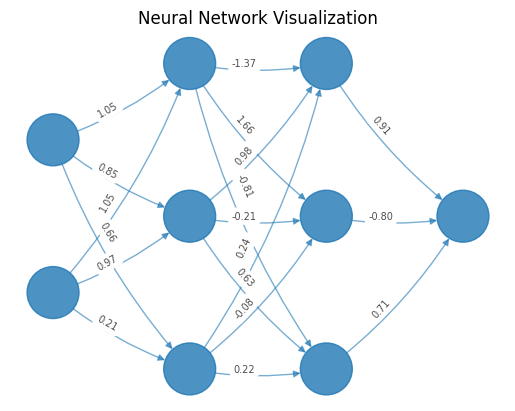

In [9]:
model.visualize()

We can also visualize the model's activations directly on one or multiple samples:

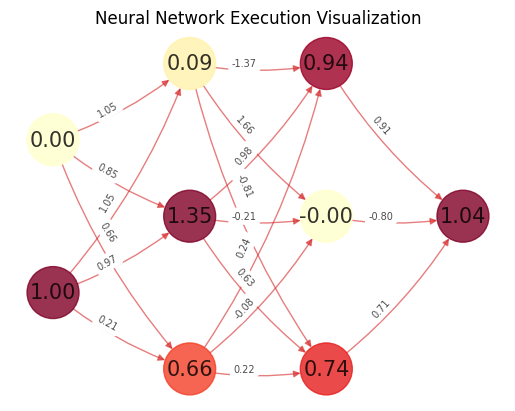

In [10]:
# Single sample
model.visualize(activations=model(torch.tensor([[0.0, 1.0]], dtype=torch.float32, device=device), return_activations=True))

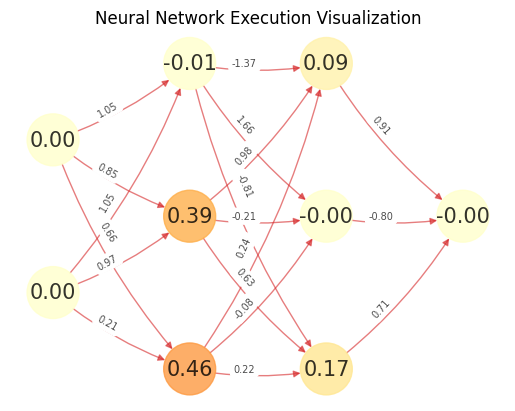

In [11]:
# All basic (unperturbed) samples
model.visualize(activations=model(torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]], dtype=torch.float32, device=device), return_activations=True))

### Where-then-what

Let's now visualize the circuits for which at least one valid grounding was found. The `visualize_as_grid` function allows us to visualize multiple circuits, formulas or mappings at the same time.

**Note :** We are limiting the number of circuits passed to the function to avoid performance issues.

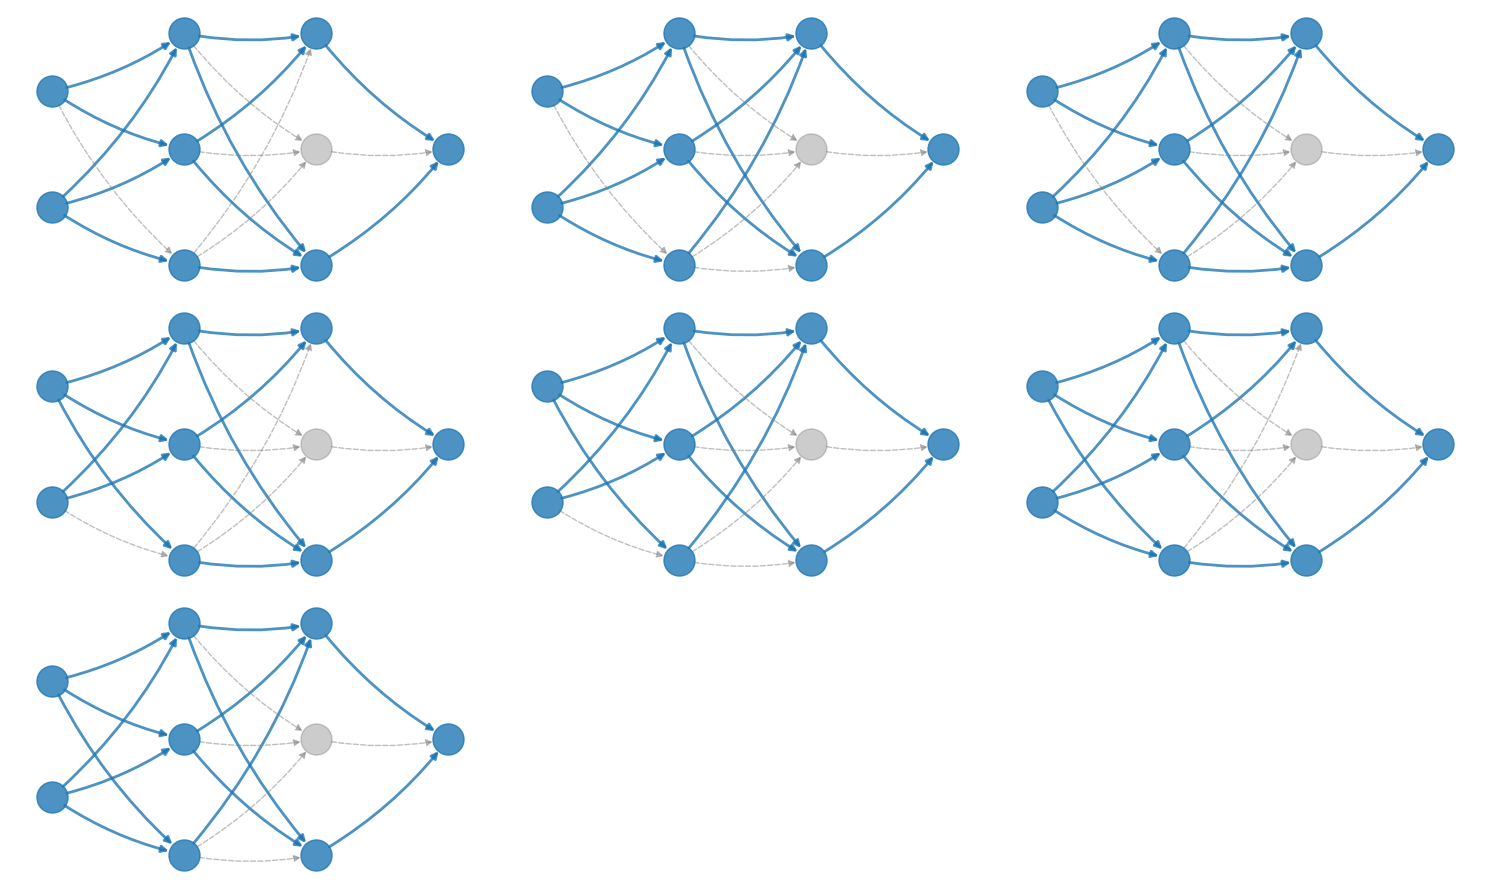

In [12]:
visualize_as_grid(circuits[:50])

Let's now arbitrarily choose the first skeleton. We can visualize it individually using the `visualize` method (which is called by the `visualize_as_grid` function), as well as display its groundings.

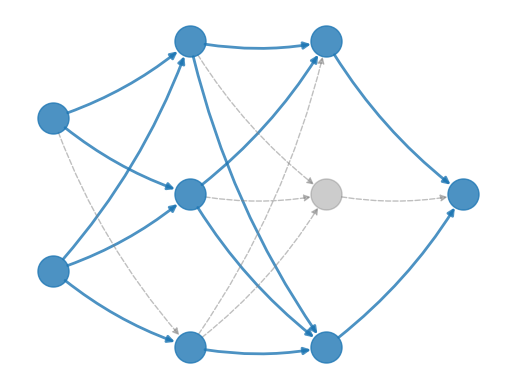

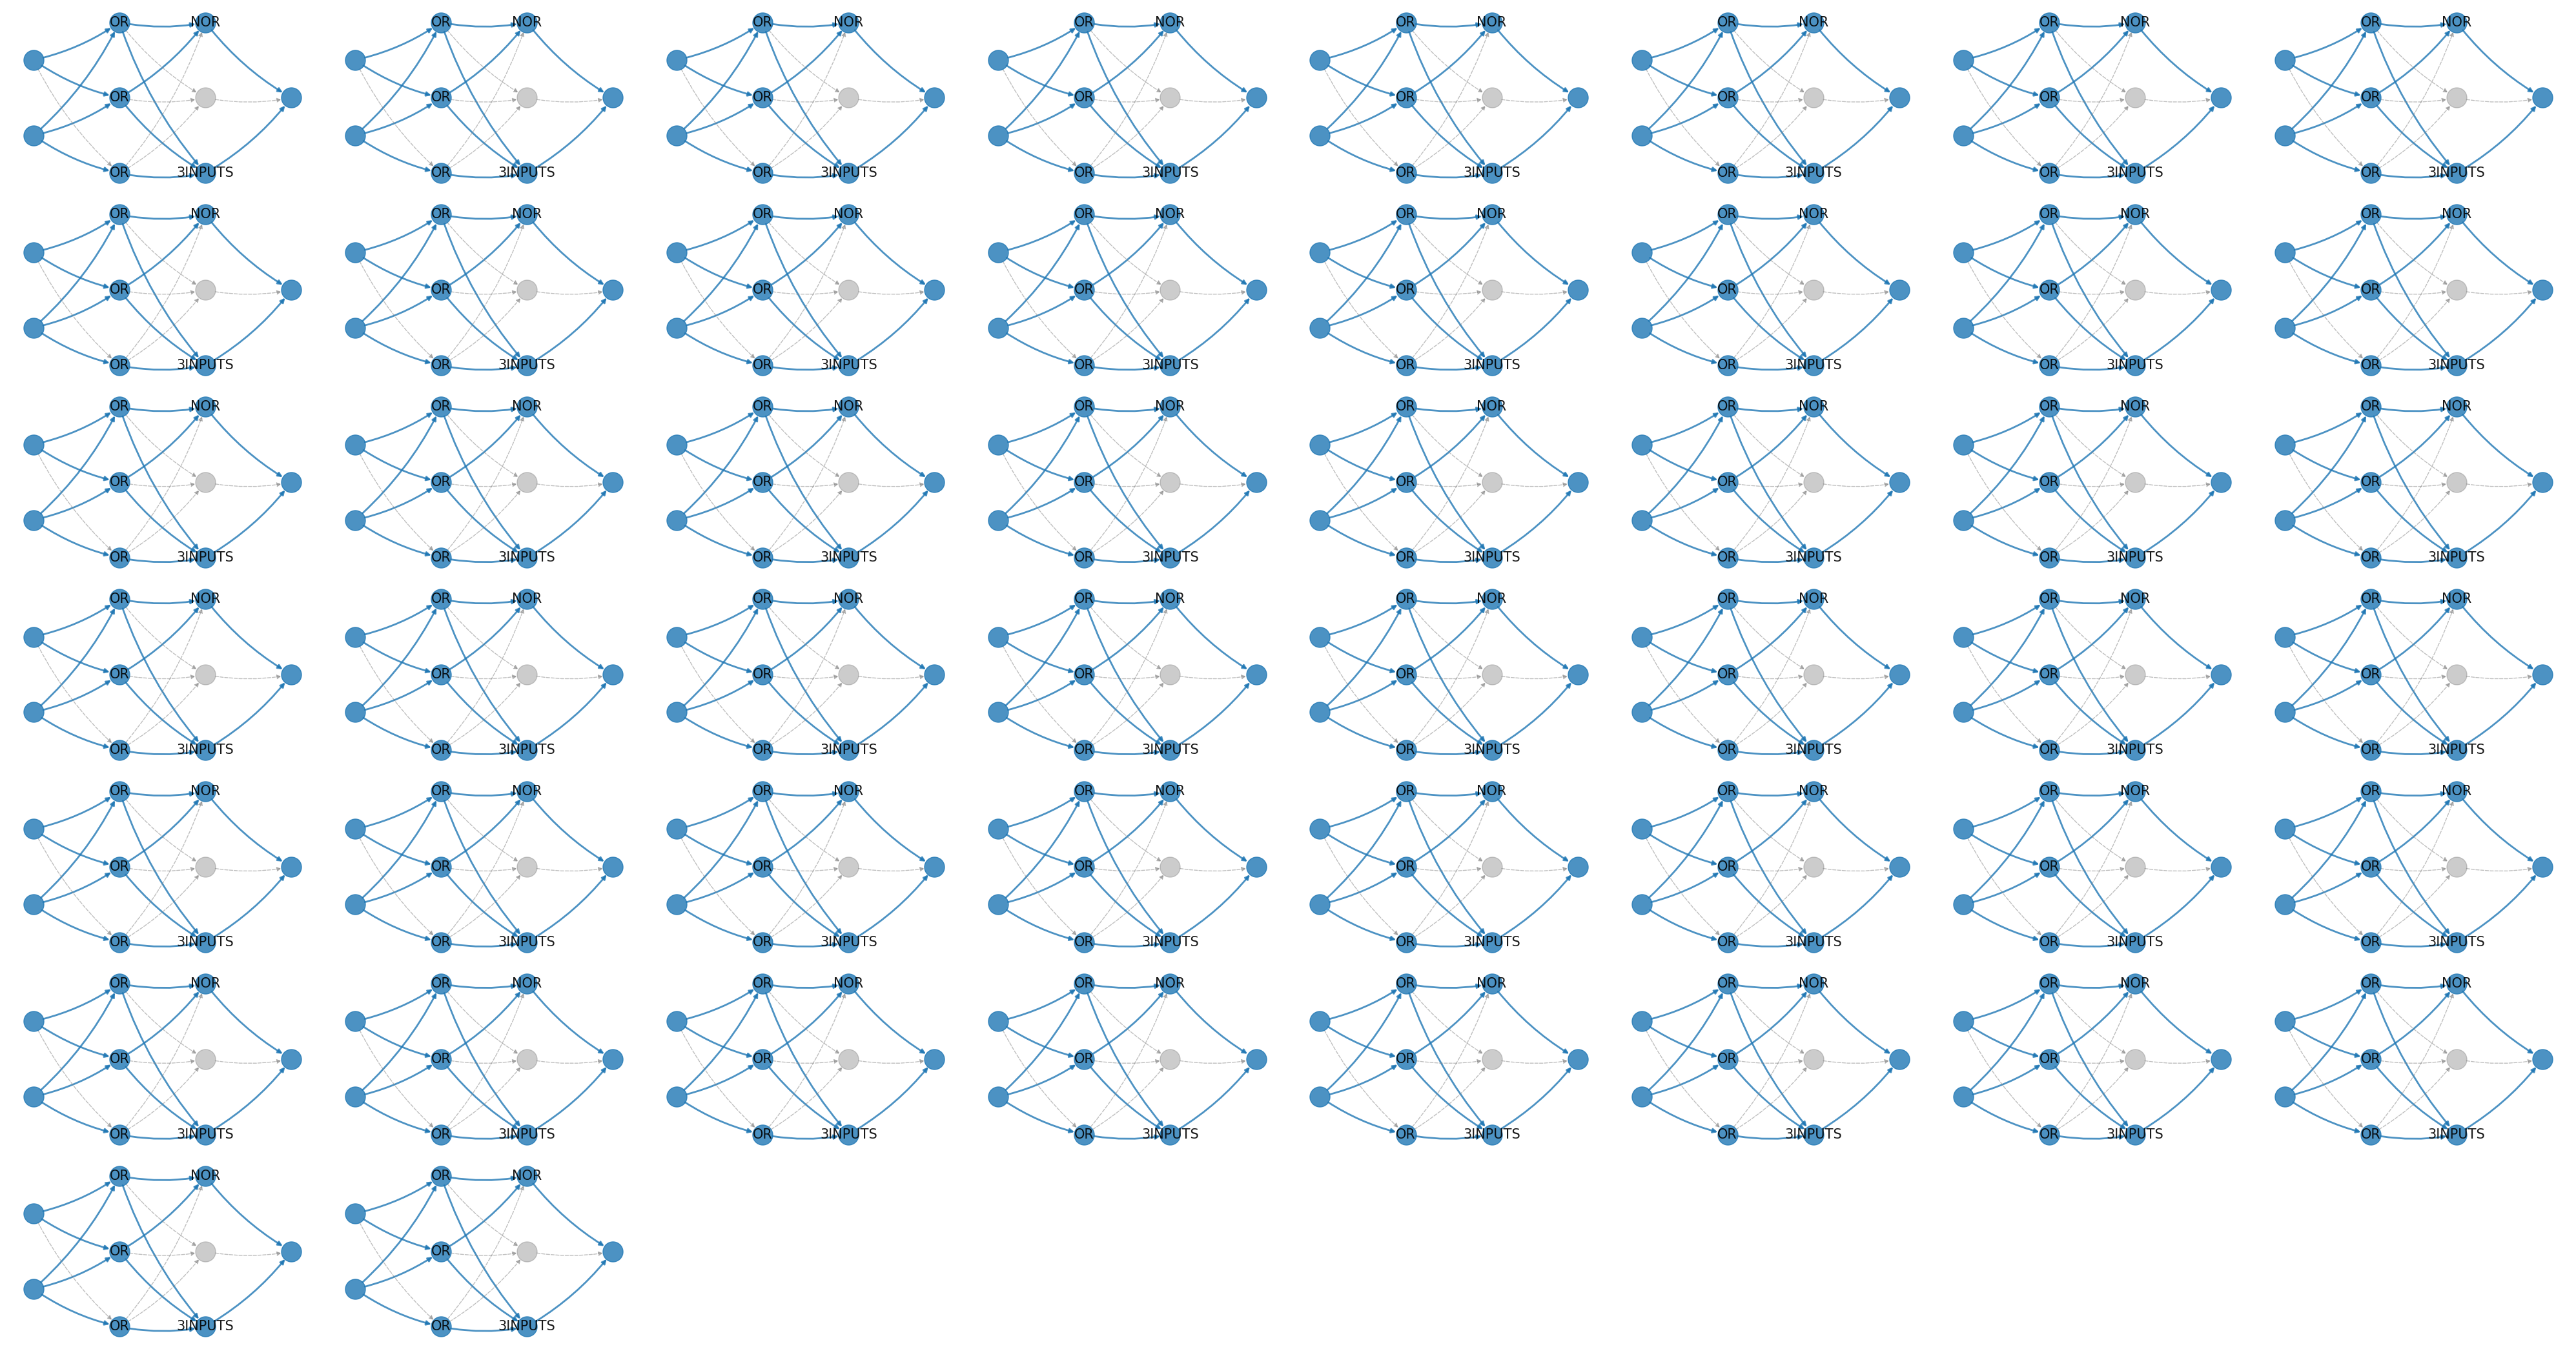

In [13]:
circuit = circuits[0]
circuit.visualize()

groundings = [g for g in all_groundings if g.circuit == circuit]
visualize_as_grid(groundings[:50])

### What-then-where

Similarly, let's now visualize all formulas (algorithms) for which at least one valid mapping was found.

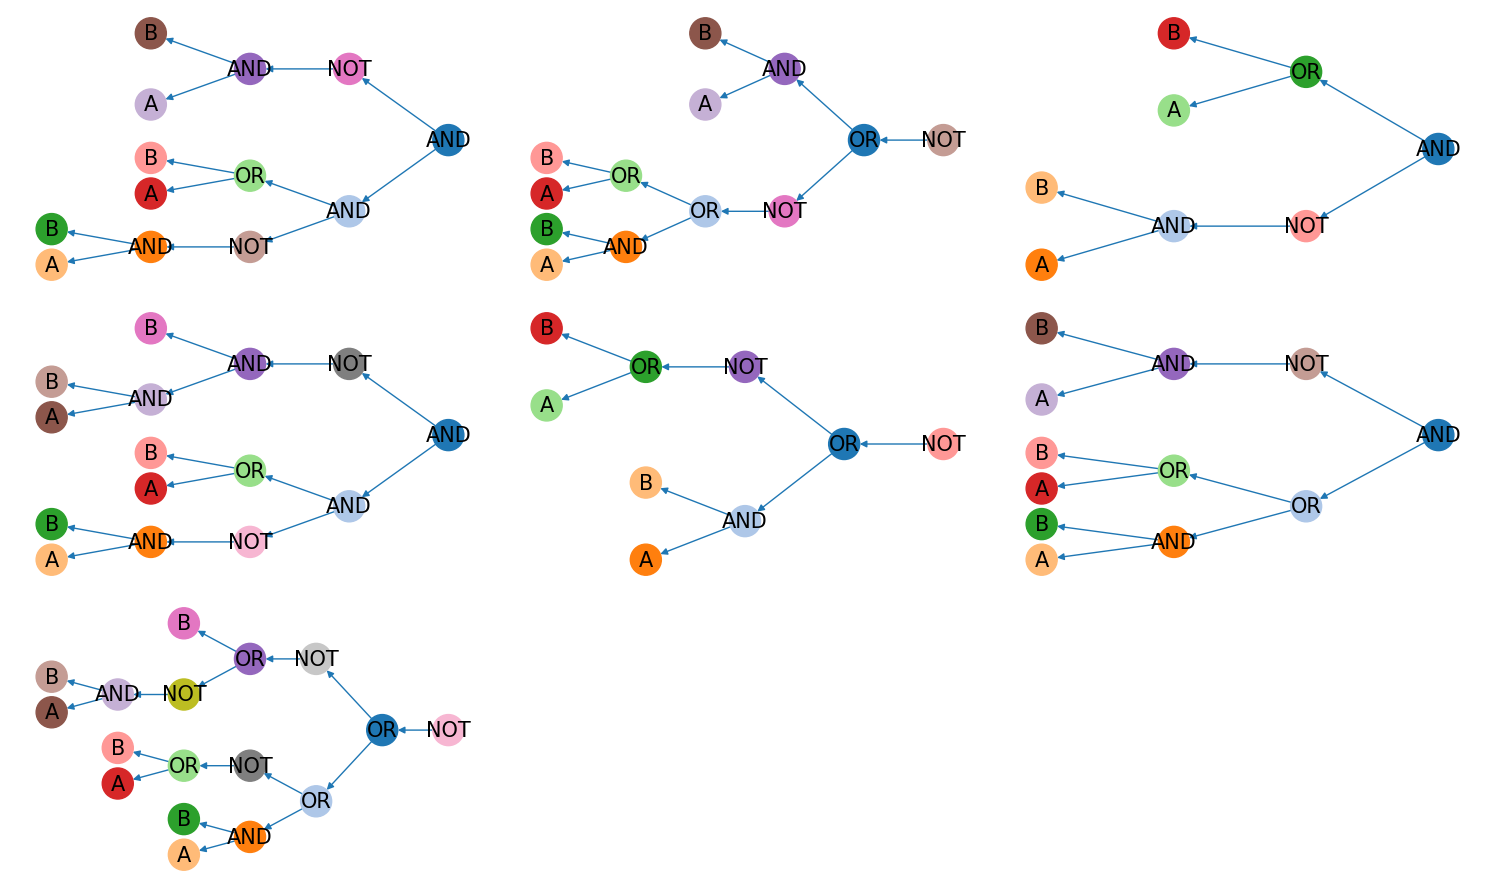

In [14]:
formulas = {m.formula for m in all_mappings}
visualize_as_grid(formulas)

Let's now arbitrarily choose the first formula, visualize it on its own, and see all mappings which were found for this formula.

Mappings are depicted by the color of the corresponding high-level node. Only intermediate nodes are taken into account; as the input and output nodes of the formula trivially correspond to the neuron's inputs and outputs. Furthermore, NOT gates can be ignored, since they can be merged in either the following or previous gate.

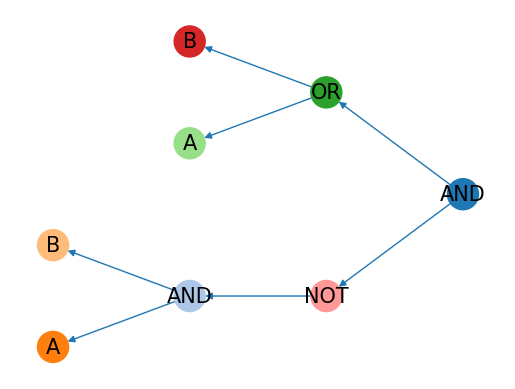

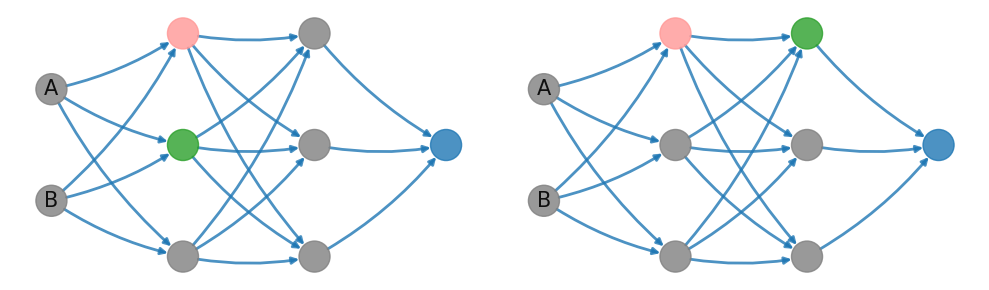

In [15]:
formula = all_mappings[0].formula
formula.visualize()

mappings = [m for m in all_mappings if m.formula == formula]
visualize_as_grid(mappings)

Finally, individual mappings can be viewer using the `visualize` method.

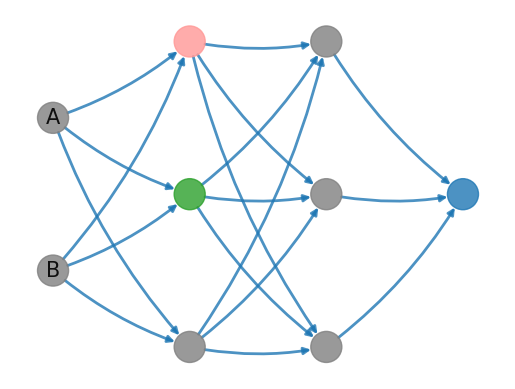

In [16]:
mappings[0].visualize()